In [10]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations, product
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
from decorators import *
from smartprint import smartprint as sprint
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN
import mmcv
from mmtrack.apis import inference_mot, init_model as init_tracking_model
# import plotly
# from pandas_profiling import ProfileReport

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

emb_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_emb/session_emb_info_new'
os.makedirs(emb_analysis_session_data,exist_ok=True)

embmatched_id_raw_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/embmatched_id_raw'
os.makedirs(embmatched_id_raw_data_dir,exist_ok=True)

embmatched_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/embmatched_id_maps'
os.makedirs(embmatched_id_map_data_dir, exist_ok=True)

cross_session_input_data_dir = f'{SERVER_CACHE_DIR}/analysis_emb/cross_session_input'
os.makedirs(cross_session_input_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_emb/session_matching_info_new'
os.makedirs(id_viz_cache_root, exist_ok=True)

## Get frame file data for all sessions

In [11]:

frame_file_data = {}
for course_idx, course_dir in enumerate(glob.glob(f"{base_dir}/*")):
    course_name = course_dir.split("/")[-1]
    course_cache_file = f"{track_analysis_meta_cache}/{course_name}"
    if os.path.exists(course_cache_file):
        frame_file_data[course_name] = pickle.load(open(course_cache_file,"rb"))
        continue
    frame_file_data[course_name]={}
        
    for session_idx, session_dir in enumerate(glob.glob(f"{course_dir}/*")):
        session_name = session_dir.split("/")[-1]
        frame_file_data[course_name][session_name] = {}
        frame_files = glob.glob(f"{session_dir}/*")
        frame_file_names = [xr.split("/")[-1] for xr in frame_files]
        if 'end.pb' in frame_file_names:
            frame_file_data[course_name][session_name]['is_completed']=True
        else:
            frame_file_data[course_name][session_name]['is_completed']=False            
        frame_ids = [int(xr.split(".")[0]) for xr in frame_file_names if not (xr=='end.pb')]
        frame_file_data[course_name][session_name]['frame_ids'] = sorted(frame_ids)
        frame_file_data[course_name][session_name]['dir_location'] = session_dir
        print(f"Got metadata for course: {course_idx}-{course_name}, session:{session_idx}-{session_name}")
    pickle.dump(frame_file_data[course_name],open(course_cache_file,"wb")) 
        
frame_file_data.keys()

dict_keys(['05748A', '05410B', '17214C', '17214B', '05681A', '24352A', '24352C', '86375A'])

In [12]:
session_filter_list = [
 'classinsight-cmu_05681A_ghc_4301_201905011630',
 'classinsight-cmu_05681A_ghc_4301_201904171630',
 'classinsight-cmu_05681A_ghc_4301_201902201630',
 'classinsight-cmu_05681A_ghc_4301_201904101630',
 'classinsight-cmu_05681A_ghc_4301_201901231630',
                       
 # 'classinsight-cmu_05418A_ghc_4102_201902251200',
 # 'classinsight-cmu_05418A_ghc_4102_201904081200',
 # 'classinsight-cmu_05418A_ghc_4102_201905011200',
 # 'classinsight-cmu_05418A_ghc_4102_201904291200',
 # 'classinsight-cmu_05418A_ghc_4102_201904011200',
                       
 'classinsight-cmu_05748A_ghc_4101_201902141630',
 'classinsight-cmu_05748A_ghc_4101_201904021630',
 'classinsight-cmu_05748A_ghc_4101_201902051630',
 'classinsight-cmu_05748A_ghc_4101_201902281630',
 'classinsight-cmu_05748A_ghc_4101_201903071630',
                       
 # 'classinsight-cmu_21127J_ghc_4102_201904230930',
 # 'classinsight-cmu_21127J_ghc_4102_201903260930',
 # 'classinsight-cmu_21127J_ghc_4102_201904160930',
 # 'classinsight-cmu_21127J_ghc_4102_201904300930',
 # 'classinsight-cmu_21127J_ghc_4102_201903190930',
                       
 # 'classinsight-cmu_05410A_ghc_4301_201904151500',
 # 'classinsight-cmu_05410A_ghc_4301_201902251500',
 # 'classinsight-cmu_05410A_ghc_4301_201904081500',
 # 'classinsight-cmu_05410A_ghc_4301_201904221500',
 # 'classinsight-cmu_05410A_ghc_4301_201902181500',
                       
 'classinsight-cmu_17214B_ph_a21_201902271030',
 'classinsight-cmu_17214B_ph_a21_201903061030',
 'classinsight-cmu_17214B_ph_a21_201904031030',
 'classinsight-cmu_17214B_ph_a21_201904101030',
 'classinsight-cmu_17214B_ph_a21_201904241030',
                       
 'classinsight-cmu_17214C_ph_225b_201903201130',
 'classinsight-cmu_17214C_ph_225b_201904101130',
 'classinsight-cmu_17214C_ph_225b_201904171130',
 'classinsight-cmu_17214C_ph_225b_201904241130',
 'classinsight-cmu_17214C_ph_225b_201905011130',
                       
 'classinsight-cmu_05410B_ghc_4211_201902111500',
 'classinsight-cmu_05410B_ghc_4211_201903181500',
 'classinsight-cmu_05410B_ghc_4211_201904081500',
 'classinsight-cmu_05410B_ghc_4211_201904151500',
 'classinsight-cmu_05410B_ghc_4211_201904221500',
 'classinsight-cmu_05410B_ghc_4211_201901281500'
]

# Get vizualization for single session

In [13]:
sample_course = '05748A'
sample_session_id = 'classinsight-cmu_05748A_ghc_4101_201902141630-front'
session_tracking_cache_file = f"{track_analysis_session_data}/{sample_session_id}.pb"
session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{sample_session_id}.pb"
session_frame_dir = f'{base_dir}/{sample_course}/{sample_session_id}'
session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sample_session_id.split("-front")[0]}/{sample_session_id}.avi'
session_frame_dir

'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face//05748A/classinsight-cmu_05748A_ghc_4101_201902141630-front'

In [14]:
old_to_new_id_map = pickle.load(open(session_preprocessed_id_map_file,"rb"))
df_session_eligible_pairs = pd.read_csv(f"{embmatched_id_map_data_dir}/{sample_session_id}.csv")
# Correct new ids with dict from eligible pairs
eligible_id_map_dict = {}
for id_pair in df_session_eligible_pairs.id_pair.values:
    (id1, id2) = eval(id_pair)
    print(id1, id2)
    if id2 in eligible_id_map_dict:
        eligible_id_map_dict[id1] = eligible_id_map_dict[id2]
    else:
        eligible_id_map_dict[id2] = id1

sprint(eligible_id_map_dict)

# correct created eligible map for once more
for key in sorted(list(eligible_id_map_dict.keys())):
    key_value = eligible_id_map_dict[key]
    if key_value in eligible_id_map_dict.keys():
        eligible_id_map_dict[key] = eligible_id_map_dict[key_value]
sprint(eligible_id_map_dict) 
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 
sprint("replacing ids in old to new id maps")
for old_id in old_to_new_id_map:
    if old_to_new_id_map[old_id] in eligible_id_map_dict:
        print(f"replacing {old_id}:{old_to_new_id_map[old_id]} -->{eligible_id_map_dict[old_to_new_id_map[old_id]]}")
        old_to_new_id_map[old_id] = eligible_id_map_dict[old_to_new_id_map[old_id]]
# sprint({kr:old_to_new_id_map[kr] for kr in old_to_new_id_map if (not old_to_new_id_map[kr]==10000)}) 


2 35
3 32
3 33
12 36
20 26
25 29
Dict: eligible_id_map_dict
Key: Value


{26: 20, 29: 25, 32: 3, 33: 3, 35: 2, 36: 12}

Dict: eligible_id_map_dict
Key: Value


{26: 20, 29: 25, 32: 3, 33: 3, 35: 2, 36: 12}

"replacing ids in old to new id maps" : replacing ids in old to new id maps
replacing 729:26 -->20
replacing 866:29 -->25
replacing 984:32 -->3
replacing 1036:33 -->3
replacing 1200:35 -->2
replacing 1246:36 -->12
replacing 1196:32 -->3
replacing 1157:33 -->3
replacing 1178:33 -->3
replacing 1233:32 -->3


In [15]:
# map processed ids to tracking df
df_tracking_new = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
total_idxs = df_tracking_new.index.max()
for old_id in old_to_new_id_map:
    new_id = old_to_new_id_map[old_id]
    if not new_id==10000:
        new_id_col = f'N{new_id}'
        if new_id_col not in df_tracking_new:
            df_tracking_new[new_id_col] = None
        df_tracking_new[new_id_col] =  df_tracking_new[new_id_col].where(~df_tracking_new[new_id_col].isnull(), df_tracking_new[old_id])
    df_tracking_new = df_tracking_new.drop(old_id, axis=1)




In [16]:
col_start_stop_idxs = []
for col in df_tracking_new.columns:
    one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stop['id'] = df_id_start_stop['id'].apply(lambda x: int(x[1:]))
df_id_start_stop

,id,min_idx,max_idx,total_idxs
0,0,0,71736,71736
1,1,0,71736,71736
2,2,0,71736,71736
3,3,0,66210,66210
4,4,0,71736,71736
5,5,0,71736,71736
6,6,0,71736,71736
7,7,0,52224,52224
8,8,0,71736,71736
9,9,60,71736,71676


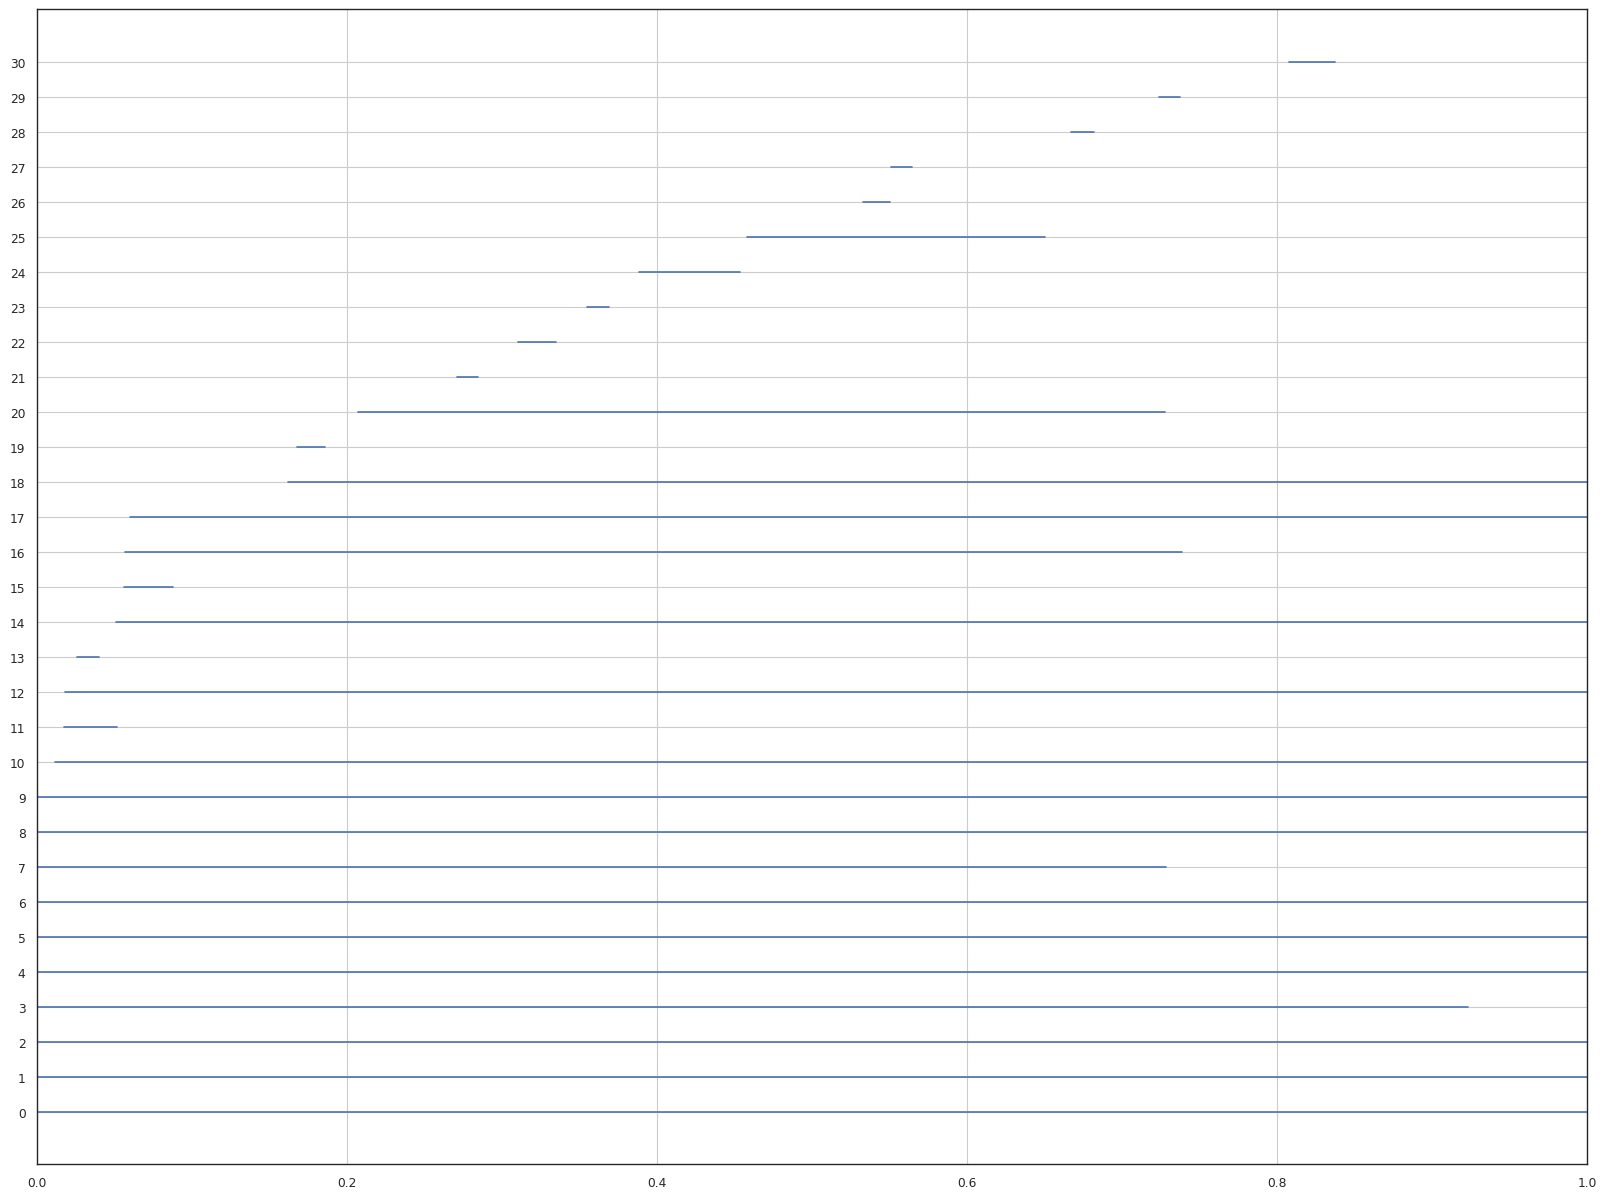

In [17]:
_ = plt.figure(figsize=(20,15))
for row_idx, row in df_id_start_stop.iterrows():
    plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs)
plt.yticks(range(df_id_start_stop.shape[0]), range(df_id_start_stop.shape[0]))
plt.grid() 

In [18]:
session_frames = df_tracking_new.index.values.tolist()
session_ids_covered = []
selected_frames = []
segments = []
segment_half_size = 50
for row_idx, row in df_id_start_stop.sort_values(by='total_idxs').iterrows():
    id_start, id_stop = row['min_idx'],row['max_idx']
    seg_mid = (id_start+id_stop)/2
    seg_start, seg_end = max(seg_mid-segment_half_size, 0), min(seg_mid+segment_half_size, total_idxs)
    is_id_covered = df_id_start_stop.apply(lambda row: (seg_end<=row['max_idx']) & (seg_start>=row['min_idx']),axis=1)
    seg_ids_covered = df_id_start_stop[is_id_covered]['id']
    new_ids_covered = [xr for xr in seg_ids_covered if xr not in session_ids_covered]
    if len(new_ids_covered)>0:        
        segment_frames = [xr for xr in session_frames if ((xr>=seg_start) and (xr<=seg_end))]
        selected_frames+=segment_frames
        segments.append((seg_start, seg_end, new_ids_covered, segment_frames))
        session_ids_covered+=new_ids_covered

sprint(segments)
    
    


List: segments


[
    (
        19868.5,
        19968.5,
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 17, 18, 20, 21],
        [
            19869,
            19872,
            19875,
            19878,
            19881,
            19884,
            19887,
            19890,
            19893,
            19896,
            19899,
            19902,
            19905,
            19908,
            19911,
            19914,
            19917,
            19920,
            19923,
            19926,
            19929,
            19932,
            19935,
            19938,
            19941,
            19944,
            19947,
            19950,
            19953,
            19956,
            19959,
            19962,
            19965,
            19968
        ]
    ),
    (
        39946.0,
        40046.0,
        [25, 28],
        [
            39948,
            39951,
            39954,
            39957,
            39960,
            39963,
            39966,
            39969,
            39972,
            39975,
            39978,
            39981,
            39984,
            39987,
            39990,
            39993,
            39996,
            39999,
            40002,
            40005,
            40008,
            40011,
            40014,
            40017,
            40020,
            40023,
            40026,
            40029,
            40032,
            40035,
            40038,
            40041,
            40044
        ]
    ),
    (
        52345.0,
        52445.0,
        [31],
        [
            52347,
            52350,
            52353,
            52356,
            52359,
            52362,
            52365,
            52368,
            52371,
            52374,
            52377,
            52380,
            52383,
            52386,
            52389,
            52392,
            52395,
            52398,
            52401,
            52404,
            52407,
            52410,
            52413,
            52416,
            52419,
            52422,
            52425,
            52428,
            52431,
            52434,
            52437,
            52440,
            52443
        ]
    ),
    (
        2321.5,
        2421.5,
        [11, 13],
        [
            2322,
            2325,
            2328,
            2331,
            2334,
            2337,
            2340,
            2343,
            2346,
            2349,
            2352,
            2355,
            2358,
            2361,
            2364,
            2367,
            2370,
            2373,
            2376,
            2379,
            2382,
            2385,
            2388,
            2391,
            2394,
            2397,
            2400,
            2403,
            2406,
            2409,
            2412,
            2415,
            2418,
            2421
        ]
    ),
    (
        25909.0,
        26009.0,
        [23],
        [
            25911,
            25914,
            25917,
            25920,
            25923,
            25926,
            25929,
            25932,
            25935,
            25938,
            25941,
            25944,
            25947,
            25950,
            25953,
            25956,
            25959,
            25962,
            25965,
            25968,
            25971,
            25974,
            25977,
            25980,
            25983,
            25986,
            25989,
            25992,
            25995,
            25998,
            26001,
            26004,
            26007
        ]
    ),
    (
        48335.5,
        48435.5,
        [30],
        [
            48336,
            48339,
            48342,
            48345,
            48348,
            48351,
            48354,
            48357,
            48360,
            48363,
            48366,
            48369,
            48372,
            48375,
            48378,
            48381,
            48384,
        

In [13]:
SOURCE_ROOT = '/home/prasoon/video_analysis/edusenseV2compute/compute/videoV3'
run_config = {
    'track_config':f'{SOURCE_ROOT}/configs/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half.py',
    'track_checkpoint':f'{SOURCE_ROOT}/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth',
    'device':'cuda:1',
}


In [14]:
# for given frame ranges get video frames and tracking results
all_frames = mmcv.VideoReader(session_video_file)

required_frame_ids = np.unique(sorted(selected_frames))
frame_data_dict = {}

for frame_idx, frame_img in enumerate(all_frames):
    if (frame_idx in required_frame_ids) & (frame_idx%3==0):
        frame_data_dict[frame_idx] = frame_img
    if frame_idx%10000==0:
        print(f"Looped {frame_idx} images")

[h264 @ 0x9b55e00] error while decoding MB 80 98, bytestream -9
[h264 @ 0x9b55e00] error while decoding MB 83 94, bytestream -15
[h264 @ 0x9b55e00] error while decoding MB 77 111, bytestream -7
[h264 @ 0x9d99b00] error while decoding MB 80 98, bytestream -9
[h264 @ 0xa5e8f80] error while decoding MB 83 94, bytestream -15
[h264 @ 0xa6d78c0] error while decoding MB 77 111, bytestream -7
[h264 @ 0xa6ebcc0] error while decoding MB 140 132, bytestream -7
[h264 @ 0xa7288c0] error while decoding MB 69 79, bytestream -5
[h264 @ 0xa5e8f80] error while decoding MB 83 94, bytestream -15
[h264 @ 0x9d99b00] error while decoding MB 80 98, bytestream -9
[h264 @ 0xa6d78c0] error while decoding MB 77 111, bytestream -7
[h264 @ 0xa6ebcc0] error while decoding MB 140 132, bytestream -7
[h264 @ 0xa7288c0] error while decoding MB 69 79, bytestream -5


Looped 0 images


[h264 @ 0x9a46580] error while decoding MB 97 95, bytestream -7
[h264 @ 0xa6ebcc0] error while decoding MB 25 82, bytestream -5
[h264 @ 0xc3a7ec0] error while decoding MB 96 92, bytestream -5
[h264 @ 0xc6e48c0] error while decoding MB 175 54, bytestream -11
[h264 @ 0xc477100] error while decoding MB 135 62, bytestream -7
[h264 @ 0x9a46580] error while decoding MB 146 92, bytestream -5
[h264 @ 0xc6e48c0] error while decoding MB 130 36, bytestream -9
[h264 @ 0xa7144c0] cabac decode of qscale diff failed at 172 33
[h264 @ 0xa7144c0] error while decoding MB 172 33, bytestream 449734
[h264 @ 0x9a46580] error while decoding MB 102 98, bytestream -5
[h264 @ 0xa6c34c0] error while decoding MB 154 107, bytestream -17
[h264 @ 0x9d99b00] error while decoding MB 124 26, bytestream -16
[h264 @ 0xc3a7ec0] error while decoding MB 154 83, bytestream -15
[h264 @ 0xc615580] error while decoding MB 151 87, bytestream -23
[h264 @ 0xa6af0c0] error while decoding MB 162 132, bytestream -5
[h264 @ 0xc615580]

Looped 10000 images


[h264 @ 0xcde5cc0] error while decoding MB 174 90, bytestream -5
[h264 @ 0xc477100] error while decoding MB 149 69, bytestream -11
[h264 @ 0xa6c34c0] error while decoding MB 123 94, bytestream -8
[h264 @ 0x9d99b00] cabac decode of qscale diff failed at 199 103
[h264 @ 0x9d99b00] error while decoding MB 199 103, bytestream 15711
[h264 @ 0xa7144c0] error while decoding MB 183 63, bytestream -7
[h264 @ 0xc6e48c0] error while decoding MB 141 65, bytestream -5
[h264 @ 0xc615580] error while decoding MB 133 42, bytestream -16
[h264 @ 0xa6ebcc0] cabac decode of qscale diff failed at 127 89
[h264 @ 0xa6ebcc0] error while decoding MB 127 89, bytestream 139660
[h264 @ 0xa7288c0] error while decoding MB 173 90, bytestream -13
[h264 @ 0xa7288c0] error while decoding MB 180 106, bytestream -5
[h264 @ 0x9d99b00] error while decoding MB 185 85, bytestream -9
[h264 @ 0xcde5cc0] error while decoding MB 190 66, bytestream -5
[h264 @ 0xc477100] error while decoding MB 189 69, bytestream -11
[h264 @ 0xa6d

In [15]:
session_id_viz_dir = f'{id_viz_cache_root}/{sample_session_id}'
os.makedirs(session_id_viz_dir, exist_ok=True)
tracking_model =None
if tracking_model:
    printm("# Deleting Previous Model")
    del tracking_model
tracking_model = init_tracking_model(run_config['track_config'],
                                 run_config['track_checkpoint'],
                                 device=run_config['device'])
for seg_idx, (seg_start, seg_end, new_ids_covered, segment_frames) in enumerate(segments):
    seg_video_id = f'S{seg_idx}_{int(seg_start)}_{int(seg_end)}_{"_".join(map(str,new_ids_covered))}'
    match_cache_dir = f'{session_id_viz_dir}/{seg_video_id}'
    match_video_file = f'{session_id_viz_dir}/{seg_video_id}.mp4'
    if os.path.exists(match_video_file):
        continue
    print(match_video_file)
    os.makedirs(match_cache_dir, exist_ok=True)
    frame_num=0

    for frame_idx in segment_frames:
        frame_tracking_file = f"{session_frame_dir}/{frame_idx}.pb"
        if os.path.exists(frame_tracking_file) and (frame_idx in frame_data_dict):
            frame_file_out = os.path.join(match_cache_dir, f'{frame_num:06d}.jpg')
            frame_num+=1
            if os.path.exists(frame_file_out):
                continue
            frame_tracking_results = pickle.load(open(frame_tracking_file,"rb"))[1]
            for person_idx in range(len(frame_tracking_results)):
                old_id= int(frame_tracking_results[person_idx]['track_id'])
                frame_tracking_results[person_idx]['track_id'] =old_to_new_id_map[old_id]
            frame_img = deepcopy(frame_data_dict[frame_idx])
            if len(frame_tracking_results)>0:
                frame_tracking_results = {
                    'track_bboxes':[np.array([[xr['track_id']]+xr['bbox'].tolist() for xr in frame_tracking_results])],
                    'det_bboxes':[np.array([xr['bbox'].tolist() for xr in frame_tracking_results])]}
                frame_track_img = tracking_model.show_result(
                    frame_img,
                    frame_tracking_results,
                    thickness=5,
                    font_scale=.5,
                    score_thr=0.1,
                    show=False,
                    wait_time=int(1000. / 5),
                    out_file=frame_file_out,
                    backend='cv2')
            else:
                cv2.imwrite(frame_file_out,frame_img)
    
    #         break
    # break
    mmcv.frames2video(match_cache_dir, match_video_file, fps=5, fourcc='mp4v')
    print(f"Done for segment {seg_video_id}")
    # break
    
    

2023-09-04 12:42:04,010 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2023-09-04 12:42:04,083 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2023-09-04 12:42:04,085 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-09-04 12:42:04,087 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-09-04 12:42:05,842 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 320, 1, 

load checkpoint from local path: /home/prasoon/video_analysis/edusenseV2compute/compute/videoV3/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector